<a href="https://colab.research.google.com/github/LucasLessa1/X-rayBodyPart/blob/lucas1/C%C3%B3piaLucasLessaProj_CIS_Imagens_Raio_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Ajusting file


In [ ]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.5 MB/s 


In [ ]:
import cv2
import pydicom
import pandas as pd
import os
import shutil
import time
import math
import gdown
import zipfile
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import os
from PIL import Image
from google.colab.patches import cv2_imshow
import string
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
def download(id): 
    url = 'https://drive.google.com/uc?id=' + str(id)
    gdown.download(url, output = None, quiet = False)

def unzip(path): #Função para unzip
    zip = zipfile.ZipFile(path)
    zip.extractall()
    zip.close()

In [ ]:
# https://drive.google.com/file/d/1ev-r31j8oRzDlKM_toaeADO2psrA_XXm/view?usp=sharing

download('1ev-r31j8oRzDlKM_toaeADO2psrA_XXm')
unzip('/content/archive.zip')

Downloading...
From: https://drive.google.com/uc?id=1ev-r31j8oRzDlKM_toaeADO2psrA_XXm
To: /content/archive.zip
100%|██████████| 269M/269M [00:03<00:00, 87.8MB/s]


In [ ]:
#os.chdir("/content/drive/MyDrive/RAIO-X/RAIO-X/archive.zip (Unzipped Files)")
path = os.getcwd() 
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv(os.path.join('/content/sample_submission.csv'))

In [ ]:
test_df.head(5)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [ ]:
A=train_df.head(1)['SOPInstanceUID']
print(A[0][50:])

00333618114258


#Pre-processing

In [ ]:
print("Columns:")
print(train_df.columns, "\n")

print("Types in columns:")
print(train_df.dtypes, "\n")

print("Types in info:")
print(train_df.describe(), "\n")

Columns:
Index(['SOPInstanceUID', 'Target'], dtype='object') 

Types in columns:
SOPInstanceUID    object
Target            object
dtype: object 

Types in info:
                                           SOPInstanceUID Target
count                                                1738   1738
unique                                               1738     41
top     1.2.826.0.1.3680043.8.498.10025629581362719970...     3 
freq                                                    1    724 



In [ ]:
#Let's  see our Target distribution

bodyparts = {
0 : 'Abdomen' ,
1 :'Ankle' ,
2 :'Cervical Spine',
3 : 'Chest' ,
4 :'Clavicles' ,
5 :'Elbow' ,
6 :'Feet' ,
7 : 'Finger' ,
8 : 'Forearm' ,
9 : 'Hand' ,
10 : 'Hip' ,
11 : 'Knee' ,
12 : 'Lower Leg' ,
13 : 'Lumbar Spine' ,
14 : 'Others' ,
15 :'Pelvis',
16 :'Shoulder' ,
17 :'Sinus' ,
18 : 'Skull' ,
19 : 'Thigh' ,
20 :'Thoracic Spine',
21: 'Wrist',
}

##Fixing folders

In [ ]:
class Image_processing():
  def __init__(self):
    self.fileList = []

  def fixfolders(self, folder, df, dictionary):
    filelist = []
    for root, dirs, files in os.walk(f'/content/{str(folder)}'):
      for file in files:
        filelist.append(os.path.join(root,file))

    for filename in filelist:
      dicom = pydicom.dcmread(filename)
      img = dicom.pixel_array
      var = filename.split("/")
      var = var[-1]
      row = df.index[df['SOPInstanceUID']==f'{var[:-6]}'].tolist()
      target = df['Target'].iloc[row[0]]
      if len(target.strip()) > 1: 
        continue
      label = dictionary.get(int(target))
      # Important Parto so save in .png images in .bmp
      resized_img  = (np.maximum(img,0)/img.max())*255 
      im = Image.fromarray(resized_img.astype(np.uint8))
      im.show()
      im.save(os.path.join(f'/content/{folder}_img', f'{label}', f'{var[:-6]}.png'))
 
  def createfolders(self, folder):
    os.mkdir(f'/content/{folder}/') 
    #os.chdir(f'/content/{folder}') 
    for bodypart in list(bodyparts.values()):
      if os.path.isdir(f'/content/{folder}/{bodypart}') == False:
        os.mkdir(f'/content/{folder}/{bodypart}')
      else:  
          pass 

In [ ]:
#Excluir diretorios de Labels!!!!!!!!
try:
  shutil.rmtree(f'/content/train_img/')
except FileNotFoundError:
  pass

In [ ]:
#os.chdir("/content/drive/MyDrive/RAIO-X/RAIO-X/archive.zip (Unzipped Files)")
#path = os.getcwd()

#CRIAR PASTAS E SEPARAR AQUIVOS 
fix  =  Image_processing()
fix.createfolders('train_img')
fix.fixfolders('train', train_df, bodyparts)

In [ ]:
# DAQUI PRA BAIXO NÃO GARANTO NADA !!

In [ ]:
def dcmtag2table(folder, list_of_tags):

    list_of_tags = list_of_tags.copy()
    items = []
    table = []
    filelist = []

    for root, dirs, files in os.walk(folder, topdown=False):
#Adiciona os caminhos de cada imagem na lista
        for name in files:
            filelist.append(os.path.join(root, name))
    aux= 0
    for _f in filelist:
      #Em cada caminho da imagem(.dcm)
        try:
            ds = pydicom.dcmread(_f, stop_before_pixels=True)
            #Pega o Dataset de cada imagem e ler no próximo for
            items = []
            items.append(_f)
            #Adiciono o caminho em "items"
            for _tag in list_of_tags:
                if _tag in ds:
                  
                    items.append(ds.data_element(_tag).value)
                    #Adiciono a features "PhotometricInterpretation", "BitsAllocated" and "SOPInstanceUID" em "items"
                else:
                    items.append("Not found")
            
            table.append(items)
            #Adiciona tudo em uma outra lista
        except:
            print("Skipping non-DICOM: " + _f)

    df = pd.DataFrame(table, columns=["Filename", "PhotometricInterpretation", "BitsAllocated","SOPInstanceUID"])
    #Crio um data set com todos os caminhos Photometric, Bits and SOP
    return df

*   SOP Instance UID - Unique Identification
*   SOP Class UID    - 

In [ ]:
tags = ['PhotometricInterpretation','BitsAllocated', 'SOPInstanceUID' ]
dicom_tags_train =  dcmtag2table('/content/train', tags)
dicom_tags_test = dcmtag2table('/content/test', tags)

In [ ]:
dicom_tags_train

,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID
0,/content/train/train/train/1029/1.2.826.0.1.36...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.96234511949925002869...
1,/content/train/train/train/308/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12250944515020919220...
2,/content/train/train/train/308/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.51262104576214638840...
3,/content/train/train/train/921/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.57849895084414384680...
4,/content/train/train/train/921/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.10592554496378195625...
...,...,...,...,...
1733,/content/train/train/train/367/1.2.826.0.1.368...,MONOCHROME2,8,1.2.826.0.1.3680043.8.498.58996250760352585732...
1734,/content/train/train/train/367/1.2.826.0.1.368...,MONOCHROME2,8,1.2.826.0.1.3680043.8.498.71782455619707465800...
1735,/content/train/train/train/1329/1.2.826.0.1.36...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.84791765678612446017...
1736,/content/train/train/train/522/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.97335880311496226119...


In [ ]:
print(dicom_tags_train.PhotometricInterpretation.value_counts())

MONOCHROME1    1659
MONOCHROME2      79
Name: PhotometricInterpretation, dtype: int64


In [ ]:
train = dicom_tags_train.merge(train_df, on =  'SOPInstanceUID')
test = dicom_tags_test.merge(test_df,on =  'SOPInstanceUID')

In [ ]:
train.head()

,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target
0,/content/train/train/train/1029/1.2.826.0.1.36...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.96234511949925002869...,1
1,/content/train/train/train/308/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12250944515020919220...,3
2,/content/train/train/train/308/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.51262104576214638840...,3
3,/content/train/train/train/921/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.57849895084414384680...,3
4,/content/train/train/train/921/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.10592554496378195625...,3


In [ ]:
target = list(train["Target"])

In [ ]:
labels = ['Abdomen', 'Ankle', 'Cervical Spine',
       'Chest', 'Clavicles', 'Elbow', 'Feet', 'Finger', 'Forearm', 'Hand',
       'Hip', 'Knee', 'Lower Leg', 'Lumbar Spine', 'Others', 'Pelvis',
       'Shoulder', 'Sinus', 'Skull', 'Thigh', 'Thoracic Spine', 'Wrist']

## Eliminating images with more than one organ

In [ ]:
#Create Label from target
def no_to_label(label):
    label_list_string = []
    trimed_label = label.rstrip()
    label_list = trimed_label.split(" ")
    label_list = [int(i) for i in label_list]
    for label in label_list:
        label_list_string.append(bodyparts[label])
    label_string = ' and '.join(label_list_string)
    return label_string

target_list = train['Target'].tolist()
label_column = []

for label in tqdm(target_list):
    label_string = no_to_label(label)
    label_column.append(label_string)

train['Label'] = label_column
train['Label'].unique()

100%|██████████| 1738/1738 [00:00<00:00, 263175.58it/s]


array(['Ankle', 'Chest', 'Lumbar Spine', 'Pelvis',
       'Cervical Spine and Lumbar Spine and Thoracic Spine', 'Lower Leg',
       'Feet', 'Ankle and Feet', 'Hip', 'Shoulder', 'Knee', 'Sinus',
       'Clavicles', 'Elbow', 'Others', 'Abdomen',
       'Lumbar Spine and Thoracic Spine', 'Hand', 'Cervical Spine',
       'Forearm', 'Wrist', 'Abdomen and Chest', 'Hand and Wrist',
       'Knee and Lower Leg', 'Forearm and Shoulder', 'Pelvis and Thigh',
       'Finger', 'Ankle and Knee and Lower Leg', 'Finger and Hand',
       'Thoracic Spine', 'Skull', 'Hip and Thigh',
       'Hip and Knee and Thigh', 'Thigh', 'Abdomen and Pelvis',
       'Elbow and Forearm', 'Cervical Spine and Thoracic Spine',
       'Chest and Feet', 'Chest and Pelvis', 'Chest and Finger',
       'Ankle and Lower Leg'], dtype=object)

In [ ]:
train.head()

,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label
0,/content/train/train/train/1029/1.2.826.0.1.36...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.96234511949925002869...,1,Ankle
1,/content/train/train/train/308/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.12250944515020919220...,3,Chest
2,/content/train/train/train/308/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.51262104576214638840...,3,Chest
3,/content/train/train/train/921/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.57849895084414384680...,3,Chest
4,/content/train/train/train/921/1.2.826.0.1.368...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.10592554496378195625...,3,Chest


In [ ]:
aux = list(train["Label"])
index=[]
for i in range(len(aux)):
    if " and " in aux[i]:
        index.append(i)

In [ ]:
train.drop(index, axis=0, inplace=True)


In [ ]:
train["Label"].unique()

array(['Ankle', 'Chest', 'Lumbar Spine', 'Pelvis', 'Lower Leg', 'Feet',
       'Hip', 'Shoulder', 'Knee', 'Sinus', 'Clavicles', 'Elbow', 'Others',
       'Abdomen', 'Hand', 'Cervical Spine', 'Forearm', 'Wrist', 'Finger',
       'Thoracic Spine', 'Skull', 'Thigh'], dtype=object)

In [ ]:
train.Label.value_counts()

Chest             724
Others            120
Knee              102
Abdomen            80
Cervical Spine     77
Feet               70
Pelvis             67
Wrist              63
Ankle              41
Shoulder           40
Lumbar Spine       39
Hand               31
Elbow              23
Sinus              23
Hip                19
Lower Leg          19
Finger             15
Thoracic Spine     15
Forearm            12
Skull              10
Clavicles           9
Thigh               7
Name: Label, dtype: int64

In [ ]:
len(train["Label"].unique())

22

In [ ]:
 #Setting the size of images for the template
batch_size = 32
img_height = 180 
img_width = 180

In [ ]:
data_dir = "/content/train_img"


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# 80% for training 20% for test

Found 1082 files belonging to 22 classes.
Using 866 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1082 files belonging to 22 classes.
Using 216 files for validation.


In [ ]:
class_names = train_ds.class_names
print(len(class_names))

22


In [ ]:
classes = sorted(list(train.Label.unique()))
len(classes)

22

In [ ]:
for i in class_names:
  if i not in classes:
    print(i)

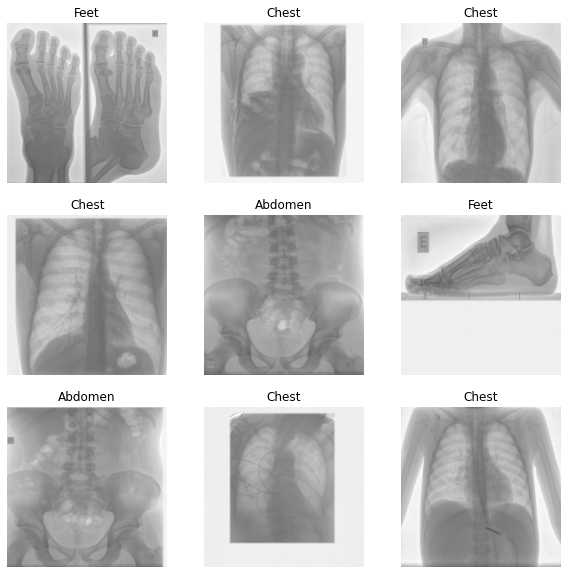

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Como visto em [tensorflow](https://www.tensorflow.org/tutorials/load_data/images) é importante deixar os valores de entrada pequenos, para isso recomenda-se utilizar uma normalização para os valores estarem entre [0, 1].

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.43549597 0.9893968


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])